In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
lag = 41
process = 2


In [4]:
summary_path = f'{protein}/summary.h5'

timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

In [28]:
data=timescales.query("process==2").query('lag==41')
data.sort_values(by='median', inplace=True, axis=0, ascending=False)


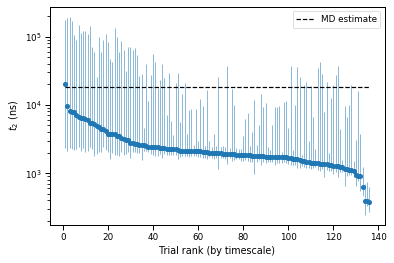

In [37]:
with sns.plotting_context('paper', font_scale=1):
    fig, ax = plt.subplots(1)
    y = data['median']
    yerr = (y-data['lb'], data['ub']-y)
    x = np.arange(y.shape[0])+1
    ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker='o', markersize=4)
    ax.set_xlabel('Trial rank (by timescale)')
    ax.set_ylabel('$t_{2}$ (ns)')
    ax.set_yscale('log')
    
    ax.hlines(md_t2[protein], x.min(), x.max(), ls='dashed', color='k', label='MD estimate')
    ax.legend()
    plt.savefig(f'{protein}/{protein}_timescales.pdf', bbox_inches='tight')

In [41]:
np.mean(data['ub']>md_t2[protein]), np.sum(data['ub']>md_t2[protein]), 

(0.45588235294117646, 62)

In [43]:
((data['median']/md_t2[protein]-1)*100).head()

54876    13.505258
13291   -46.343708
39868   -55.412951
43327   -55.628429
36375   -56.922939
Name: median, dtype: float64

In [45]:
data['median'].head()

54876    20430.946382
13291     9658.132641
39868     8025.668786
43327     7986.882735
36375     7753.871000
Name: median, dtype: float64